In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import lmfit
from scipy import special
import function as func
from scipy import interpolate
import fit_script as fit
import os

In [3]:
def gause_model(x, mean, sigma, height):
    return height * np.exp( -1./2. * ((x-mean)/sigma) ** 2.)

def gause_residual(params, x, y, yerr):
    mean = params['mean']
    sigma = params['sigma']
    height = params['height']
    y_model = gause_model(x, mean, sigma, height)
    chi = (y - y_model)/yerr
    a = np.isfinite(chi)
    return chi[a]

# Retrieve results of null tests

In [4]:
# Get fit result of null samples
pp_all = np.array([])
for start in range(18, 27, 1):
    print(start)
    path = "/data/ms2840a/other_data/Neff/null_pop_per_freq/null_pop_{}GHz.csv".format(start)
    data = func.csv_to_array(path)
    pp_all = np.append(pp_all, data["value"])

18
19
20
21
22
23
24
25
26


In [5]:
# Sort the p-local by ascending order
order = np.sort(pp_all)

# Get 95 % C.L. sigma (=$P_{DP}/\Delta P_{DP}$) from null tests

In [7]:
# Get 95 % C.L. sigma (=P_DP/Delta P_DP)
N_null = len(order)
pp_95 = 0.
for i in range(N_null):
    #if i/N_null == 0.05: 
    if i == (int)(N_null*0.05): 
        print(f'95 % C.L. = {order[N_null-i]} sigma')
        pp_95 = order[N_null-i]
        break
    pass

95 % C.L. = 1.7147120133117235 sigma


Text(1.8147120133117236, 13112542.275, '95 % C.L. = 1.715')

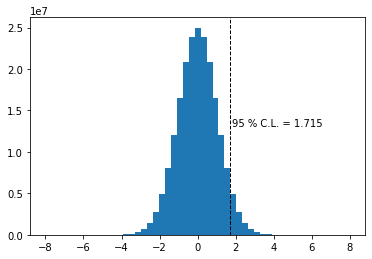

In [15]:
# Plot P_DP/Delta P_DP
n, bins, hatches = plt.hist(pp_all, bins=51, range=(-8, 8))
ymin,ymax = plt.ylim()
plt.plot([pp_95,pp_95],[0.,ymax],linestyle='--', linewidth=1, color='k')
plt.ylim(ymin,ymax)
plt.text(pp_95+0.1, ymax*0.5, f'95 % C.L. = {pp_95:.3f}')

# Plot $P_{DP}/\Delta P_{DP}$ distribution from null tests

Text(0.5, 1.0, 'null sample fit result of $P_{\\rm DP}/\\Delta P_{\\rm DP}$')

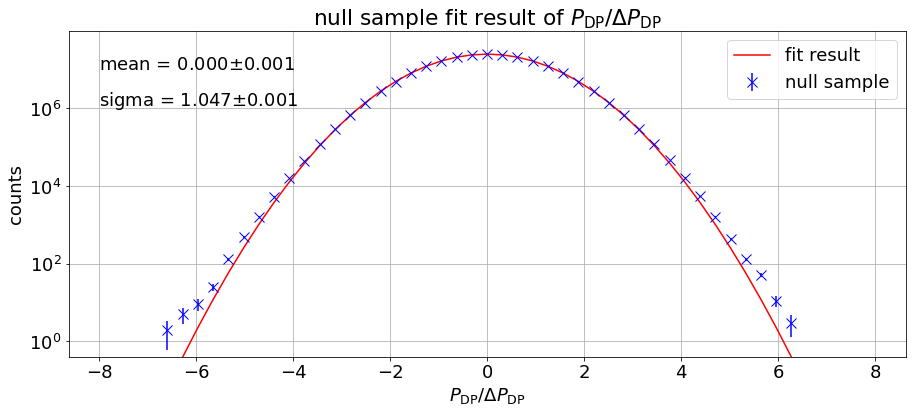

In [66]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

ne = np.sqrt(n)
x = np.array([(bins[i] + bins[i+1]) / 2 for i in range(len(n))])
col = "blue"
plt.errorbar(x, n, yerr = ne, capsize=0, fmt='x', markersize=10, ecolor=col, markeredgecolor=col, color=col, label="null sample")

params = lmfit.Parameters()
params.add('mean', value=0.)
params.add('sigma', value=1.)
params.add('height', value=1e+7)

result = lmfit.minimize(gause_residual, params, args=(x, n, ne))
height = result.params["height"].value
mean = result.params["mean"].value
mean_err = result.params["mean"].stderr
sigma = result.params["sigma"].value
sigma_err = result.params["sigma"].stderr
plt.plot(x, gause_model(x, mean, sigma, height), label="fit result", color="r")

#plt.text(0.4, 0.21, "rms = " + str(round(np.std(P/P_err), 3)), transform=ax.transAxes)
#plt.text(-8, 1e+7, "mean = " + str(round(np.abs(mean), 3)) + r"$\pm$" + str(round(mean_err, 3)))
plt.text(-8, 1e+7, "mean = " + "0.000" + r"$\pm$" + str(round(mean_err, 3)))
plt.text(-8, 1.2e+6, "sigma = " + str(round(sigma, 3)) + r"$\pm$" + str(round(sigma_err, 3)))

plt.yscale("log")
plt.legend()
plt.yticks([1, 100, 1e+4, 1e+6])
plt.ylim([0.4, 1e+8])
plt.grid()
plt.xlabel(r"$P_{\rm DP}/\Delta P_{\rm DP}$")
plt.ylabel("counts")
plt.title(r"null sample fit result of $P_{\rm DP}/\Delta P_{\rm DP}$")
#plt.savefig("../result_figure/N_eff/null_sample_pop.pdf")

# Plot $P_{DP}/\Delta P_{DP}$ distribution from data

In [116]:
# Retrieve fit results of measured data
fr = {
    "freq": np.array([]), 
    "a": np.array([]), 
    "b": np.array([]), 
    "P": np.array([]), 
    "a_err": np.array([]), 
    "b_err": np.array([]), 
    "P_err": np.array([]), 
    "redchi": np.array([])
}

for i in range(180, 265, 1):
    word = list(str(i))
    word.insert(2, ".")
    start_freq = float("".join(word))

    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)

        path = "../data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
        fit_result = func.csv_to_array(path)
        fr["freq"] = np.append(fr["freq"], fit_result["freq_0"]/1.e+9)
        fr["a"] = np.append(fr["a"], fit_result["a"])
        fr["b"] = np.append(fr["b"], fit_result["b"])
        fr["P"] = np.append(fr["P"], fit_result["P"])
        fr["a_err"] = np.append(fr["a_err"], fit_result["a_err"])
        fr["b_err"] = np.append(fr["b_err"], fit_result["b_err"])
        fr["P_err"] = np.append(fr["P_err"], fit_result["P_err"])
        fr["redchi"] = np.append(fr["redchi"], fit_result["redchi"])

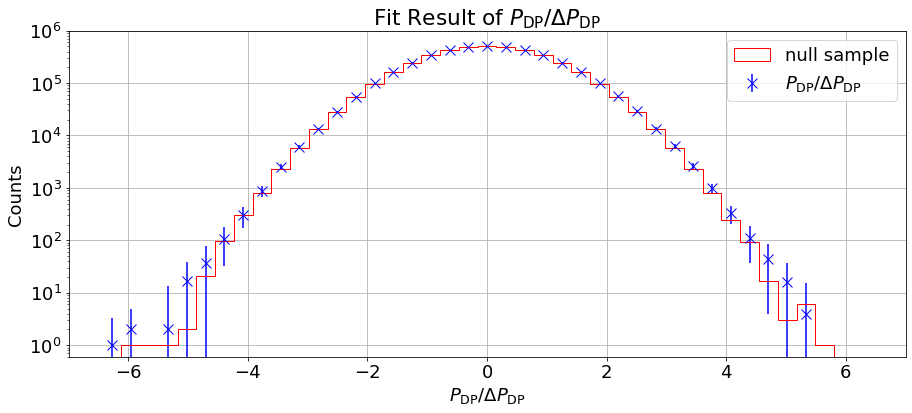

In [144]:
# Plot P_DP/Delta P_DP from data and null tests
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
nn, bins, hatches = plt.hist(fr["P"]/fr["P_err"], bins=51, range=(-8, 8), color="white")
ne = np.sqrt(n)
xx = np.array([(bins[i] + bins[i+1]) / 2 for i in range(len(n))])

xxx = []
nnn = []
nnne = []
for i, nnnn in enumerate(nn):
    if nnnn != 0:
        xxx.append(xx[i])
        nnn.append(nn[i])
        nnne.append(ne[i])
        
xx = np.array(xxx)
nn = np.array(nnn)
ne = np.array(nnne)
col = "blue"
plt.errorbar(xx, nn, yerr = ne, capsize=0, fmt='x', markersize=10, ecolor=col, markeredgecolor=col, color=col, label=r"$P_{\rm DP}/\Delta P_{\rm DP}$")

#plt.errorbar(x, n/(np.max(n)/np.max(nn)), yerr = ne, capsize=0, fmt='x', markersize=10, ecolor="red", markeredgecolor="red", color="red", label="null sample")
plt.hist(pp_all[:len(fr["P"])], bins=51, range=(-8, 8), histtype="step", color="red", label="null sample")
"""
params = lmfit.Parameters()
params.add('mean', value=0.)
params.add('sigma', value=1.)
params.add('height', value=1.5e+5)

result = lmfit.minimize(gause_residual, params, args=(x, n, ne))
h = result.params["height"].value
m = result.params["mean"].value
s = result.params["sigma"].value
me = result.params["mean"].stderr
se = result.params["sigma"].stderr
#plt.plot(x, gause_model(x, m, s, h), label="gausian fit", color="r")
print(round(m,4), round(me,4))
print(round(s,4), round(se,4))
#plt.text(-4.5, 260000, "mean = " + str(round(m, 3)) + r" $\pm$ " + str(round(me, 3)))
#plt.text(-4.5, 230000, "sigma = " + str(round(s, 3)) + r" $\pm$ " + str(round(se, 3)))
"""

plt.grid()
plt.xlabel(r"$P_{\rm DP}/\Delta P_{\rm DP}$")
plt.ylabel("Counts")
plt.title(r"Fit Result of $P_{\rm DP}/\Delta P_{\rm DP}$")
plt.yscale("log")
plt.legend()
plt.ylim([0.6,1e6])
plt.xlim([-7,7])
plt.savefig("../result_figure/fit_result/pop_data_null.pdf")
    

# Estimate Global p-Value

In [34]:
N_fit = 207900000
pop_len = func.csv_to_array("/data/ms2840a/other_data/Neff/null_pop_len.csv")

In [35]:
def get_p_local(value):
    num = int(np.floor((value+8)*1e+4))
    

    left = 0
    for i in range(18, 27, 1):
        left += np.sum(pop_len[str(i)][:num])

    for start in ["18", "19", "20", "21", "22", "23", "24", "25", "26"]:
        path = "/data/ms2840a/other_data/Neff/null_pop/{}GHz_{}.csv".format(start, num)
        data = func.csv_to_array(path)
        for d in data["value"]:
            if d < value:
                left += 1
    
    return (N_fit - left)/N_fit

In [36]:
def make_plot_data(p):
    M = 462*50 # of null samples
    x = np.array([10**-8])
    n = 1.0*len(np.where(p<x[0])[0])
    y = n/M
    ye = np.sqrt(n)/M
    while (x[-1]<0.1): 
        xx = x[-1]*2.73
        n = 1.0*len(np.where(p<xx)[0])
        yy = n/M
        yye = np.sqrt(n)/M
        x = np.append(x, xx)
        y = np.append(y, yy)
        ye = np.append(ye, yye)
        pass
    xe = np.array([0.0]*len(x))
    return (x, y, xe, ye)

In [37]:
def fit_func(x, u, N):
    return 1 - (1 - x)**(u*N)

def residual(params, x, y, ye, N):
    u = params['u']
    y_model = fit_func(x, u, N)
    chi = (y - y_model)/ye
    o = np.isfinite(chi)
    return chi[o]

def fit_Neff(x, y, ye, N):    
    params = lmfit.Parameters()
    params.add('u', value=1.)

    result = lmfit.minimize(residual, params, args=(x, y, ye, N))
    u = result.params["u"].value
    ue = result.params["u"].stderr
    
    print("mu = " + str(round(u, 3)) + r"$\pm$" + str(round(ue, 3)))
    
    return fit_func(x, u, N), str(round(u, 3)), str(round(ue, 3))

In [38]:
def plot_neff_hist(ax, f):
    data = func.csv_to_array("/data/ms2840a/other_data/Neff/null_p_local_min_per_freq/p_local_min_{}GHz.csv".format(f))
    n, bins, hatches = ax.hist(np.log10(data["value"]), bins=51, range=(-10, 0), color="white")
    ne = np.sqrt(n)
    x = np.array([(bins[i] + bins[i+1]) / 2 for i in range(len(n))])
    ax.errorbar(10**x, n, yerr = ne, capsize=0, fmt='x', markersize=10, ecolor='blue', markeredgecolor = "blue", color='blue', label=r'$p_{\rm local-min}$')
     
    ax.grid()
    ax.legend()
    ax.set_ylim([0.6, 1.5e+4])
    ax.set_xlim([1e-7, 1e-1])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$p_{\rm local-min}$")
    ax.set_ylabel("counts")
    ax.set_title("{} - {} GHz".format(float(f), float(f)+0.1))

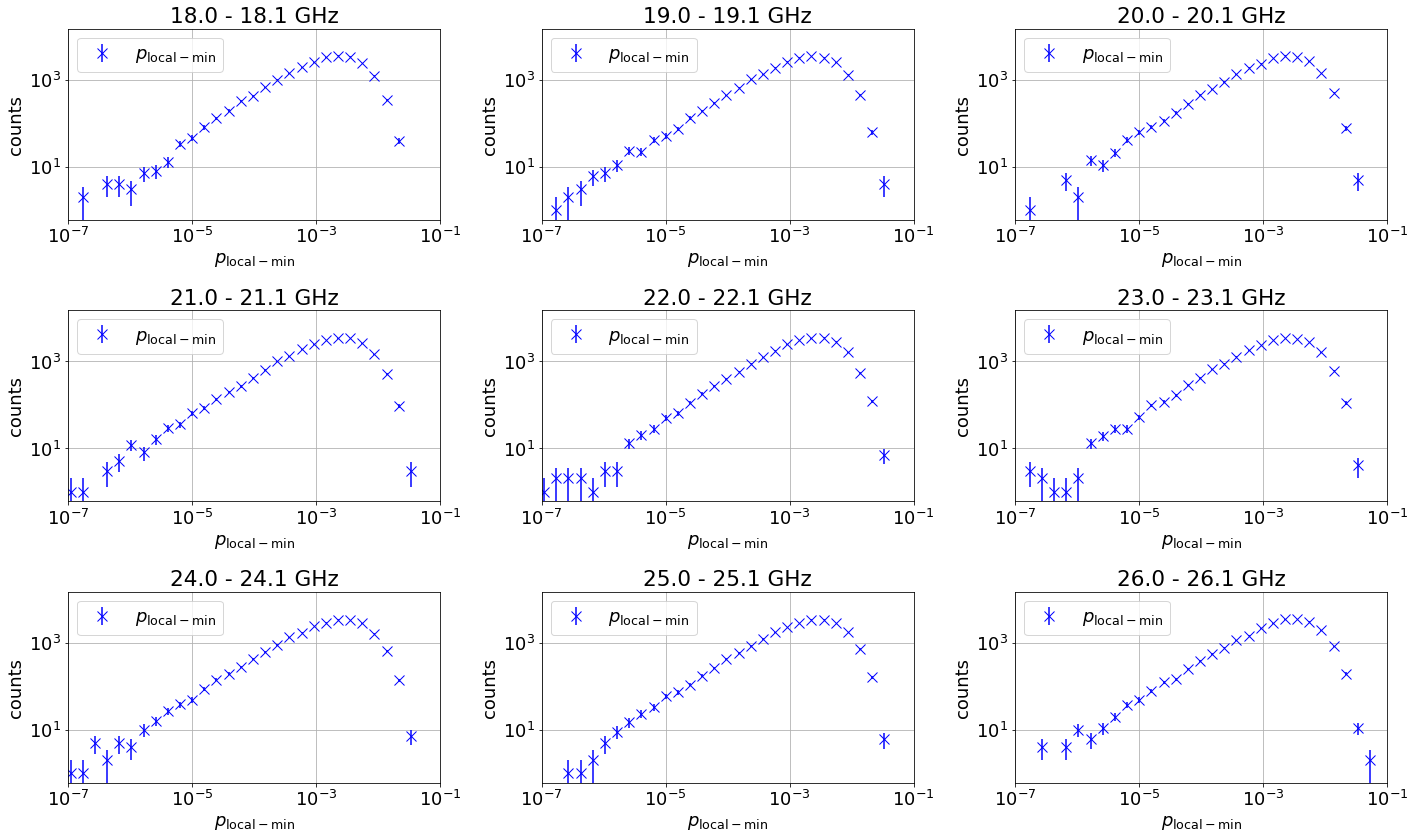

In [43]:
N = 1000

plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)

plot_neff_hist(axes[0][0], "18")
plot_neff_hist(axes[0][1], "19")
plot_neff_hist(axes[0][2], "20")
plot_neff_hist(axes[1][0], "21")
plot_neff_hist(axes[1][1], "22")
plot_neff_hist(axes[1][2], "23")
plot_neff_hist(axes[2][0], "24")
plot_neff_hist(axes[2][1], "25")
plot_neff_hist(axes[2][2], "26")

fig.tight_layout()

plt.savefig("/home/dosue/result_figure/N_eff/p_local_min_hist.pdf")

In [44]:
def p_global_fit(ax, f):
    data = func.csv_to_array("/data/ms2840a/other_data/Neff/null_p_local_min_per_freq/p_local_min_{}GHz.csv".format(f))
    x,y,xe,ye = make_plot_data(data["value"])
    yy = 1 - (1-x)**N
    
    ax.plot(x, yy, color="black",linestyle="dashed", label=r"$\mu = 1$")

    ax.set_ylim(N*10**-9, 5*10**0)
    ax.errorbar(x, y, yerr = ye, capsize=0, fmt='x', markersize=10, ecolor='blue', markeredgecolor = "blue", color='blue', label="data")

    y, u, ue = fit_Neff(x, y, ye, N)
    ax.plot(x, y, color="red", label="fit result")
    ax.text(0.4, 0.05, r"$\mu$ = " + u + r"$\pm$" + ue, transform=ax.transAxes)
    
    ax.set_title("{} - {} GHz".format(float(f), float(f)+0.1))
    ax.set_xlabel(r'$p_{\rm local}$')
    ax.set_ylabel(r'$p_{\rm global}$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    ax.legend(loc=[0.6, 0.2])
    ax.set_xlim([1e-7,1])
    
    u_array[int(f)-18] = u
    ue_array[int(f)-18] = ue

In [45]:
u_array = np.zeros(9)
ue_array = np.zeros(9)

mu = 0.427$\pm$0.006
mu = 0.423$\pm$0.01
mu = 0.399$\pm$0.009
mu = 0.408$\pm$0.011
mu = 0.374$\pm$0.007
mu = 0.387$\pm$0.01
mu = 0.388$\pm$0.012
mu = 0.363$\pm$0.01
mu = 0.332$\pm$0.01


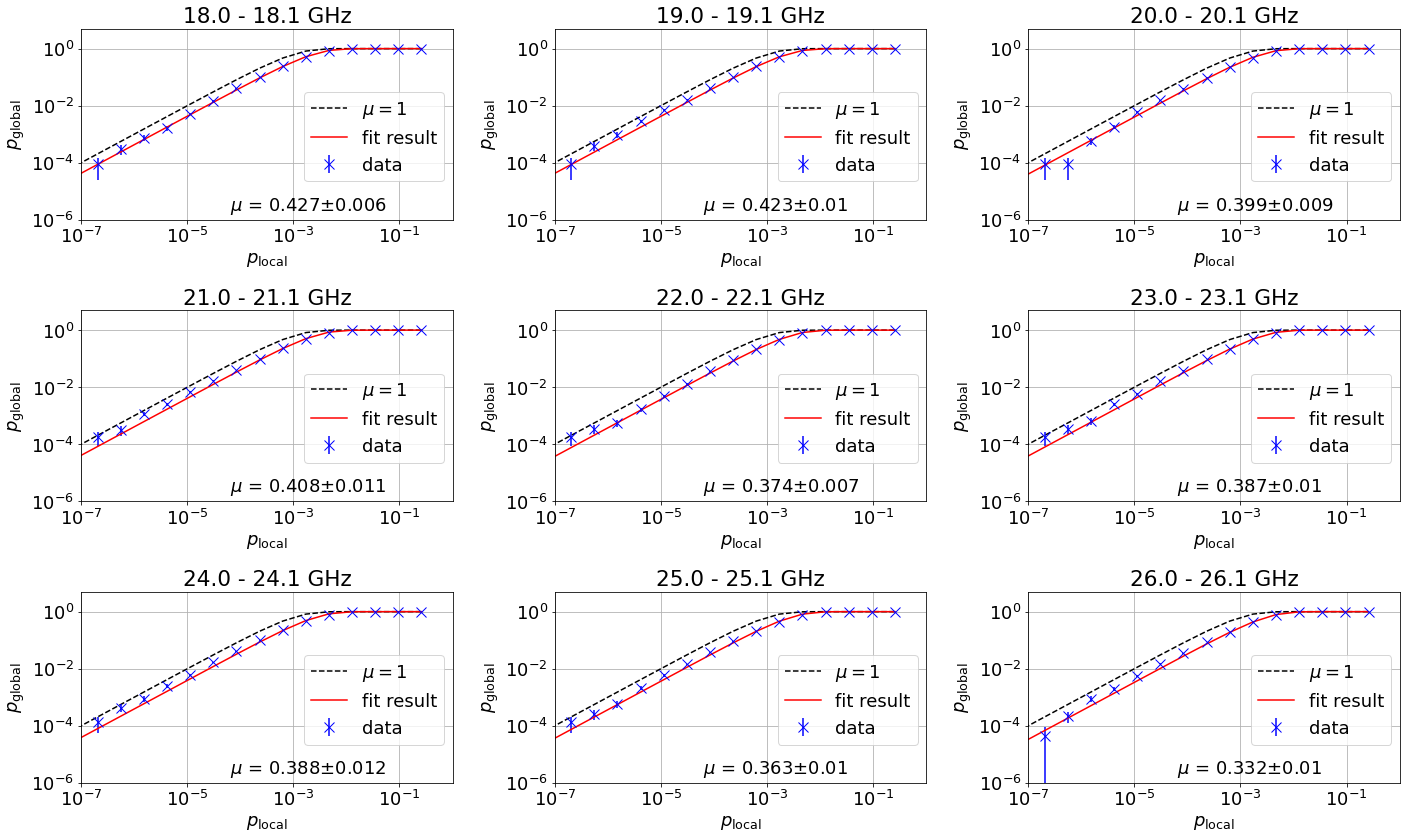

In [47]:
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)

p_global_fit(axes[0][0], "18")
p_global_fit(axes[0][1], "19")
p_global_fit(axes[0][2], "20")
p_global_fit(axes[1][0], "21")
p_global_fit(axes[1][1], "22")
p_global_fit(axes[1][2], "23")
p_global_fit(axes[2][0], "24")
p_global_fit(axes[2][1], "25")
p_global_fit(axes[2][2], "26")

fig.tight_layout()

#plt.savefig("/home/dosue/result_figure/N_eff/p_global_fit.pdf")

In [48]:
def fit_line(x, a, b):
    return a * (x-22)/22 + b

def residual_line(params, x, y, ye):
    a = params['a']
    b = params['b']
    y_model = fit_line(x, a, b)
    chi = (y - y_model)/ye
    o = np.isfinite(chi)
    return chi[o]

def fit_Neff_line(x, y, ye):    
    params = lmfit.Parameters()
    params.add('a', value=1.)
    params.add('b', value=1.)

    result = lmfit.minimize(residual_line, params, args=(x, y, ye))
    a = result.params["a"].value
    ae = result.params["a"].stderr
    b = result.params["b"].value
    be = result.params["b"].stderr
    
    print("a = " + str(round(a, 6)) + " +/- " + str(round(ae, 6)))
    print("b = " + str(round(b, 6)) + " +/- " + str(round(be, 6)))
    
    return fit_line(x, a, b), ((ae*x)**2 + be**2)**0.5, (a, ae), (b, be)

a = -0.223774 +/- 0.032014
b = 0.386894 +/- 0.003995


(-0.05, 1.05)

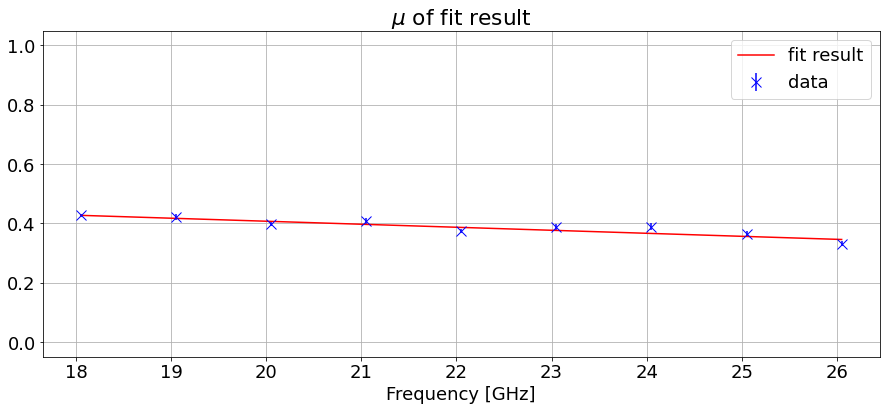

In [52]:
# Plot mu v.s. frequency
freq = np.array([i+18.05 for i in range(9)])

fig = plt.subplots(figsize=(15,6))
plt.errorbar(freq, u_array, yerr = ue_array, capsize=0, fmt='x', markersize=10, ecolor='blue', markeredgecolor = "blue", color='blue', label="data")

y, ye, (a, ae), (b, be) = fit_Neff_line(freq, u_array, ue_array)
plt.plot(freq, y, color="red", label="fit result")

plt.xlabel("Frequency [GHz]")
plt.title(r"$\mu$ of fit result")
plt.grid()
plt.legend()
plt.ylim([-0.05,1.05])
#plt.savefig("/home/dosue/result_figure/N_eff/fit_mu.pdf")

In [58]:
# Calculate averaged mu over frequency
freq_min = 18.0 # GHz
freq_max = 26.5 # GHz

print(fit_line(freq_min, a, b))
print(fit_line(freq_max, a, b))

# func: a*(x-22)/22 + b =  a/22 * x + (b-a)
# Integral: a/(2*22)*x**2 + (b-a)*x
def integral(x, a=a, b=b):
    return a/(2.*22.)*np.power(x, 2.) + (b-a)*x

print(integral(freq_min))
print(integral(freq_max))
mu_ave = ( integral(freq_max) - integral(freq_min) )/(freq_max - freq_min)
print(f'mu average over {freq_min}--{freq_max} GHz = {mu_ave}')

0.42758066364002406
0.34112236151252234
9.344245468421054
12.611233325319375
mu average over 18.0--26.5 GHz = 0.3843515125762731


# Calculate global p-Value from data

In [68]:
# Retrieve local p-Value from data
freq = []
p_local = []
redchi = []
fit_P = []
fit_a = []
fit_b = []

for k in range(180, 265, 1):
    start_freq = k/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for i in range(initial, final, 2000):
        word = list(str(i))
        word.insert(2, ".")
        start = "".join(word)
        path = "/data/ms2840a/result_data/signal_p_local/start_{}GHz.csv".format(start)
        data = func.csv_to_array(path)
        freq += data["freq_0"].tolist()
        p_local += data["p_local"].tolist()
        path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
        data = func.csv_to_array(path)
        redchi += data["redchi"].tolist()
        fit_P += data["P"].tolist()
        fit_a += data["a"].tolist()
        fit_b += data["b"].tolist()
        pass
    
    pass

freq = np.array(freq)
p_local = np.array(p_local)
redchi = np.array(redchi)
fit_P = np.array(fit_P)
fit_a = np.array(fit_a)
fit_b = np.array(fit_b)

print(f'Size of freq    = {len(freq)}')
print(f'Size of p_local = {len(p_local)}')
print(f'Size of redchi  = {len(redchi)}')
print(f'Size of fit_P   = {len(fit_P)}')
print(f'Size of fit_a   = {len(fit_a)}')
print(f'Size of fit_b   = {len(fit_b)}')

Size of freq    = 4250000
Size of p_local = 4250000
Size of redchi  = 4250000
Size of fit_P   = 4250000
Size of fit_a   = 4250000
Size of fit_b   = 4250000


Text(0.5, 1.0, 'fit result of $p_{\\rm local}$')

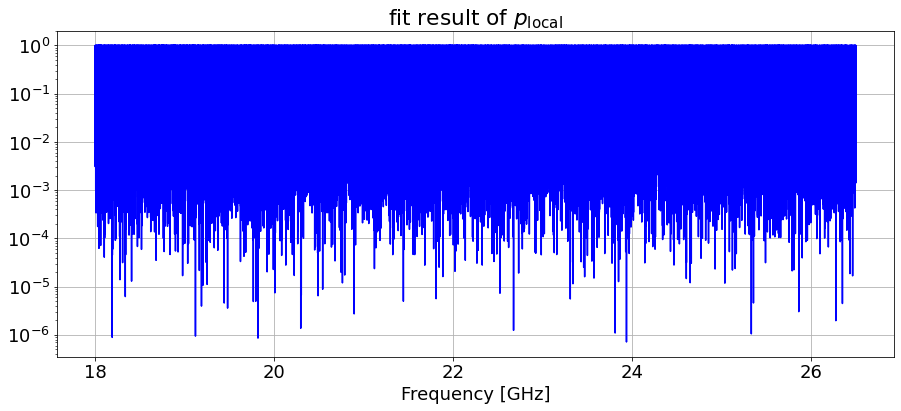

In [70]:
# Plot local p-Value
fig = plt.subplots(figsize=(15,6))
plt.rcParams["font.size"] = 18

plt.plot(freq*1e-9, p_local, color="blue")

plt.grid()
plt.yscale("log")
plt.xlabel("Frequency [GHz]")
plt.title(r"fit result of $p_{\rm local}$")
#plt.savefig("../result_figure/fit_result/p_local.pdf")

In [93]:
p_local_min = np.min(p_local)
index_p_local_min = np.where(p_local==p_local_min)[0][0]
freq_p_local_min = freq[index_p_local_min]
N_fit_all = len(freq)
p_global = 1 - (1-p_local_min)**(mu_ave * N_fit_all)

print(f'p_local minimum = {p_local_min} (@ {freq_p_local_min*1.0e-9} GHz)')
print(f'# of all fits = {N_fit_all}')
print(f'p_global = {p_global}')

p_local minimum = 7.118807118807119e-07 (@ 23.935386 GHz)
# of all fits = 4250000
p_global = 0.6874069939205575


# List-up low p-Value

In [84]:
freq_lowP = []
p_local_lowP = []
fit_P_lowP = []
fit_a_lowP = []
fit_b_lowP = []
redchi_lowP = []
for i, p in enumerate(p_local):
    if p < 1e-5:
        freq_lowP.append(freq[i])
        p_local_lowP.append(p)
        fit_P_lowP.append(fit_P[i])
        fit_a_lowP.append(fit_a[i])
        fit_b_lowP.append(fit_b[i])
        redchi_lowP.append(redchi[i])
        print(
            str(freq[i]/1e9) + " & " + 
            str(round(fit_P[i]*1e19, 2)) + " & " + 
            str(round(fit_a[i]*1e26, 2)) + " & " + 
            str(round(fit_b[i]*1e19, 2)) + " & " + 
            str(round(p*1e6,2)) + " & " + 
            str(round(redchi[i],2)) + " \\\\")
        pass
    pass
print(f'# of fit with p_local<1e-5 = {len(freq_lowP)}')
print()

# Remove adjacent results
print('###############################################')
print('Remove adjacent results')
diff_freq_lowP = np.diff(freq_lowP)
close_lowP = (diff_freq_lowP < 2.1e+3) # Hz
_plocal_close = []
_index_close = []
remove_index = []
for i, isclose in enumerate(close_lowP):
    if isclose:
        _plocal_close.append(p_local_lowP[i])
        _index_close.append(i)
    else:
        if len(_plocal_close)>0:
            # check lowest p_local
            _plocal_close.append(p_local_lowP[i])
            _index_close.append(i)
            _plocal_min = min(_plocal_close)
            _index_min = _index_close[_plocal_close.index(_plocal_min)]
            # append removing index datas
            for _ind in _index_close:
                if _ind != _index_min:
                    remove_index.append(_ind)
                    pass
            # clear 
            _plocal_close = []
            _index_close = []
            pass
        pass
    pass

i = len(close_lowP)
if len(_plocal_close)>0:
    # check lowest p_local
    _plocal_close.append(p_local_lowP[i])
    _index_close.append(i)
    _plocal_min = min(_plocal_close)
    _index_min = _index_close[_plocal_close.index(_plocal_min)]
    # append removing index datas
    for _ind in _index_close:
        if _ind != _index_min:
            remove_index.append(_ind)
            pass
        pass
    pass

freq_lowP = [ f for i, f in enumerate(freq_lowP) if i not in remove_index ]
p_local_lowP = [ f for i, f in enumerate(p_local_lowP) if i not in remove_index ]
fit_P_lowP = [ f for i, f in enumerate(fit_P_lowP) if i not in remove_index ]
fit_a_lowP = [ f for i, f in enumerate(fit_a_lowP) if i not in remove_index ]
fit_b_lowP = [ f for i, f in enumerate(fit_b_lowP) if i not in remove_index ]
redchi_lowP = [ f for i, f in enumerate(redchi_lowP) if i not in remove_index ]

# print
for i in range(len(freq_lowP)):
    print(
        str(freq_lowP[i]/1e9) + " & " + 
        str(round(fit_P_lowP[i]*1e19, 2)) + " & " + 
        str(round(fit_a_lowP[i]*1e26, 2)) + " & " + 
        str(round(fit_b_lowP[i]*1e19, 2)) + " & " + 
        str(round(p_local_lowP[i]*1e6,2)) + " & " + 
        str(round(redchi_lowP[i],2)) + " \\\\")   
    pass
        

freq_lowP = np.array(freq_lowP)
p_local_lowP = np.array(p_local_lowP)
fit_P_lowP = np.array(fit_P_lowP)
fit_a_lowP = np.array(fit_a_lowP)
fit_b_lowP = np.array(fit_b_lowP)
redchi_lowP = np.array(redchi_lowP)
print(f'# of fit with p_local<1e-5 = {len(freq_lowP)}')

18.19081 & 0.84 & 1.72 & 2.48 & 0.92 & 0.79 \\
18.190812 & 0.84 & 1.51 & 2.48 & 0.89 & 0.8 \\
18.190814 & 0.79 & 1.28 & 2.48 & 3.01 & 0.82 \\
18.336724 & 0.76 & 1.13 & 2.4 & 6.22 & 0.65 \\
19.120508 & 0.68 & 0.49 & 1.49 & 6.18 & 0.81 \\
19.12051 & 0.72 & 0.51 & 1.49 & 2.15 & 0.79 \\
19.120512 & 0.74 & 0.65 & 1.49 & 1.11 & 0.79 \\
19.120514 & 0.73 & 0.84 & 1.48 & 0.94 & 0.75 \\
19.187772 & 1.03 & -0.53 & 4.17 & 3.95 & 0.82 \\
19.187774 & 1.01 & -0.46 & 4.16 & 6.71 & 0.83 \\
19.441606 & 1.05 & -0.14 & 3.94 & 4.57 & 0.83 \\
19.479506 & 0.84 & -2.84 & 2.68 & 3.58 & 0.64 \\
19.766974 & 0.84 & -1.13 & 2.48 & 4.91 & 0.74 \\
19.766976 & 0.82 & -1.17 & 2.48 & 8.18 & 0.75 \\
19.794366 & 0.79 & -0.36 & 2.8 & 4.97 & 0.61 \\
19.794368 & 0.77 & -0.52 & 2.8 & 8.22 & 0.62 \\
19.819068 & 0.94 & -1.74 & 3.39 & 7.22 & 0.66 \\
19.81907 & 1.01 & -1.85 & 3.39 & 1.38 & 0.62 \\
19.819072 & 1.03 & -1.84 & 3.39 & 0.86 & 0.61 \\
19.819074 & 0.96 & -1.93 & 3.39 & 3.86 & 0.63 \\
20.00798 & 0.92 & -1.44 & 2.5 & 7.4

# Plot low p-Value fit

In [39]:
def get_marumoji(val):
    # ①を文字コードに変換[bytes型]
    maru_date = "①".encode("UTF8")
    # ①を文字コードに変換[int型]
    maru_code = int.from_bytes(maru_date, 'big')
    # 文字コードの変換
    maru_code += val - 1
    # 文字コードを文字に変換して返却
    return maru_code.to_bytes(4, "big").decode("UTF8")

In [85]:
def plot_peak(f0, ax, xmin, ymin, number):
    base = np.floor(f0/1e7)/1e2
    
    for k in range(180, 264, 1):
        start_freq = k/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)

        for i in range(initial, final, 2000):
            word = list(str(i))
            word.insert(2, ".")
            start = "".join(word)

            if float(start) < f0/1e9 and f0/1e9 < float(start)+2e-3:
                path = "/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]+data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
                freq, W, We = func.rebin_func(data["freq"], W)
                ax.errorbar((freq/1e+9-base)*1e3, W*1e19, yerr=We*1e19, fmt='o', markersize=4, ecolor='blue', markeredgecolor = "blue", color='blue', label=r"$P_{\rm in}(\nu)$")

                path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                for p in range(len(data["freq_0"])):
                    if int(data["freq_0"][p]) == int(f0):
                        freq = np.arange(f0-50e3, f0+200e3, 2e3)
                        y = fit.fit_func(freq, data["a"][p], data["b"][p], data["P"][p], f0)
                        ax.plot((freq/1e+9-base)*1e3, y*1e19, linewidth=3, color="red", label="fit result")
                    
    ax.grid()
    ax.legend(loc="upper right")
    
    if xmin != -1: ax.set_xlim([xmin, xmin + 0.5])
    if ymin != 0: ax.set_ylim([ymin, ymin + 0.4])
    
    #ax.set_yticks([ymin + 0.1, ymin + 0.2, ymin + 0.3, ymin + 0.4])
    ax.set_xlabel("Frequency [MHz + {} GHz]".format(base))
    ax.set_ylabel(r"Power [$\times 10^{-19}$ W]")
    ax.set_title(str(number) + ": " + r" $\nu_0 = {}$ GHz".format(f0/1e9))

In [86]:
def plot_peak2(f0, ax, xmin, ymin, number):
    base = np.floor(f0/1e7)/1e2
    
    for k in range(180, 264, 1):
        start_freq = k/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)

        for i in range(initial, final, 2000):
            word = list(str(i))
            word.insert(2, ".")
            start = "".join(word)

            if float(start) < f0/1e9 - 2e-3 and f0/1e9 - 2e-3 < float(start) + 2e-3: 
                path = "/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]+data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
                freq, W, We = func.rebin_func(data["freq"], W)
                ax.errorbar((freq/1e+9-base)*1e3, W*1e19, yerr=We*1e19, fmt='o', markersize=4, ecolor='blue', markeredgecolor = "blue", color='blue', label=r"$P_{\rm in}(\nu)$")

                path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                for p in range(len(data["freq_0"])):
                    if int(data["freq_0"][p]) == int(f0):
                        freq = np.arange(f0-50e3, f0+200e3, 2e3)
                        y = fit.fit_func(freq, data["a"][p], data["b"][p], data["P"][p], f0)
                        ax.plot((freq/1e+9-base)*1e3, y*1e19, linewidth=3, color="red", label="fit result")
                    
    ax.grid()
    ax.legend(loc="upper right")
    
    if xmin != -1: ax.set_xlim([xmin, xmin + 0.5])
    if ymin != 0: ax.set_ylim([ymin, ymin + 0.4])
    
    #ax.set_yticks([ymin + 0.1, ymin + 0.2, ymin + 0.3, ymin + 0.4])
    ax.set_xlabel("Frequency [MHz + {} GHz]".format(base))
    ax.set_ylabel(r"Power [$\times 10^{-19}$ W]")
    ax.set_title(str(number) + ": " + r" $\nu_0 = {}$ GHz".format(f0/1e9))

In [59]:
18190812000.0 8.850408850408851e-07
18336724000.0 6.21933621933622e-06
19120514000.0 9.427609427609428e-07
19187772000.0 3.949013949013949e-06
19441606000.0 4.56950456950457e-06
19479506000.0 3.5834535834535835e-06

19766974000.0 4.911014911014911e-06
19794366000.0 4.973544973544974e-06
19819072000.0 8.561808561808562e-07
20007980000.0 7.421837421837422e-06
20296620000.0 1.3708513708513709e-06
20302788000.0 6.705146705146705e-06

20490250000.0 6.464646464646465e-06
20541586000.0 8.811928811928811e-06
20893242000.0 2.7224627224627225e-06
21443168000.0 4.983164983164983e-06
21808598000.0 5.622895622895623e-06
22522234000.0 7.291967291967292e-06

22673946000.0 1.240981240981241e-06
23307606000.0 5.550745550745551e-06
23808666000.0 1.0918710918710918e-06
23935386000.0 4.401154401154401e-06
25329956000.0 1.0485810485810486e-06
25353898000.0 4.583934583934584e-06

25860092000.0 3.0254930254930254e-06
26274234000.0 1.967291967291967e-06
26347692000.0 4.4684944684944685e-06


plot_peak(18190812000.0, axes[0][0], 0.6, 2.3, "1st")
plot_peak(18336724000.0, axes[1][0], 6.5, 2.2, "2nd")
plot_peak(19120514000.0, axes[2][0], 0.3, 1.3, "3rd")
plot_peak2(19187772000.0, axes[3][0], 7.5, 4, "4th")
plot_peak(19441606000.0, axes[4][0], 1.4, 3.8, "5th")
plot_peak(19479506000.0, axes[5][0], 9.3, 2.5, "6th")

plot_peak(19766974000.0, axes[0][0], 6.7, 2.3, "7th")
plot_peak(19794366000.0, axes[1][0], 4.1, 2.6, "8th")
plot_peak(19819072000.0, axes[2][0], 8.8, 3.2, "9th")
plot_peak2(20007980000.0, axes[3][0], 7.7, 2.3, "10th")
plot_peak(20296620000.0, axes[4][0], 6.4, 2.65, "11st")
plot_peak(20302788000.0, axes[5][0], 2.5, 2.7, "12nd")

plot_peak(20490250000.0, axes[0][0], 0, 2.1, "13th")
plot_peak(20541586000.0, axes[1][0], 1.4, 2.05, "14th")
plot_peak(20893242000.0, axes[2][0], 3., 1.8, "15th")
plot_peak(21443168000.0, axes[3][0], 2.9, 1.8, "16th")
plot_peak(21808598000.0, axes[4][0], 8.4, 1.9, "17th")
plot_peak(22522234000.0, axes[5][0], 2., 2.85, "18th")

plot_peak2(22673946000.0, axes[0][0], 3.7, 2.15, "19th")
plot_peak(23307606000.0, axes[1][0], 7.4, 3.7, "20th")
plot_peak(23808666000.0, axes[2][0], 8.4, 3.1, "21st")
plot_peak(23935386000.0, axes[3][0], 5.2, 2.85, "22nd")
plot_peak2(25329956000.0, axes[4][0], 9.7, 3.1, "23rd")
plot_peak2(25353898000.0, axes[5][0], 3.7, 2.5, "24th")

plot_peak(25860092000.0, axes[0][0], -0.1, 4.43, "25th")
plot_peak(26274234000.0, axes[1][0], 4, 4.35, "26th")
plot_peak(26347692000.0, axes[2][0], 7.5, 3.4, "27th")

SyntaxError: invalid syntax (1991076969.py, line 1)

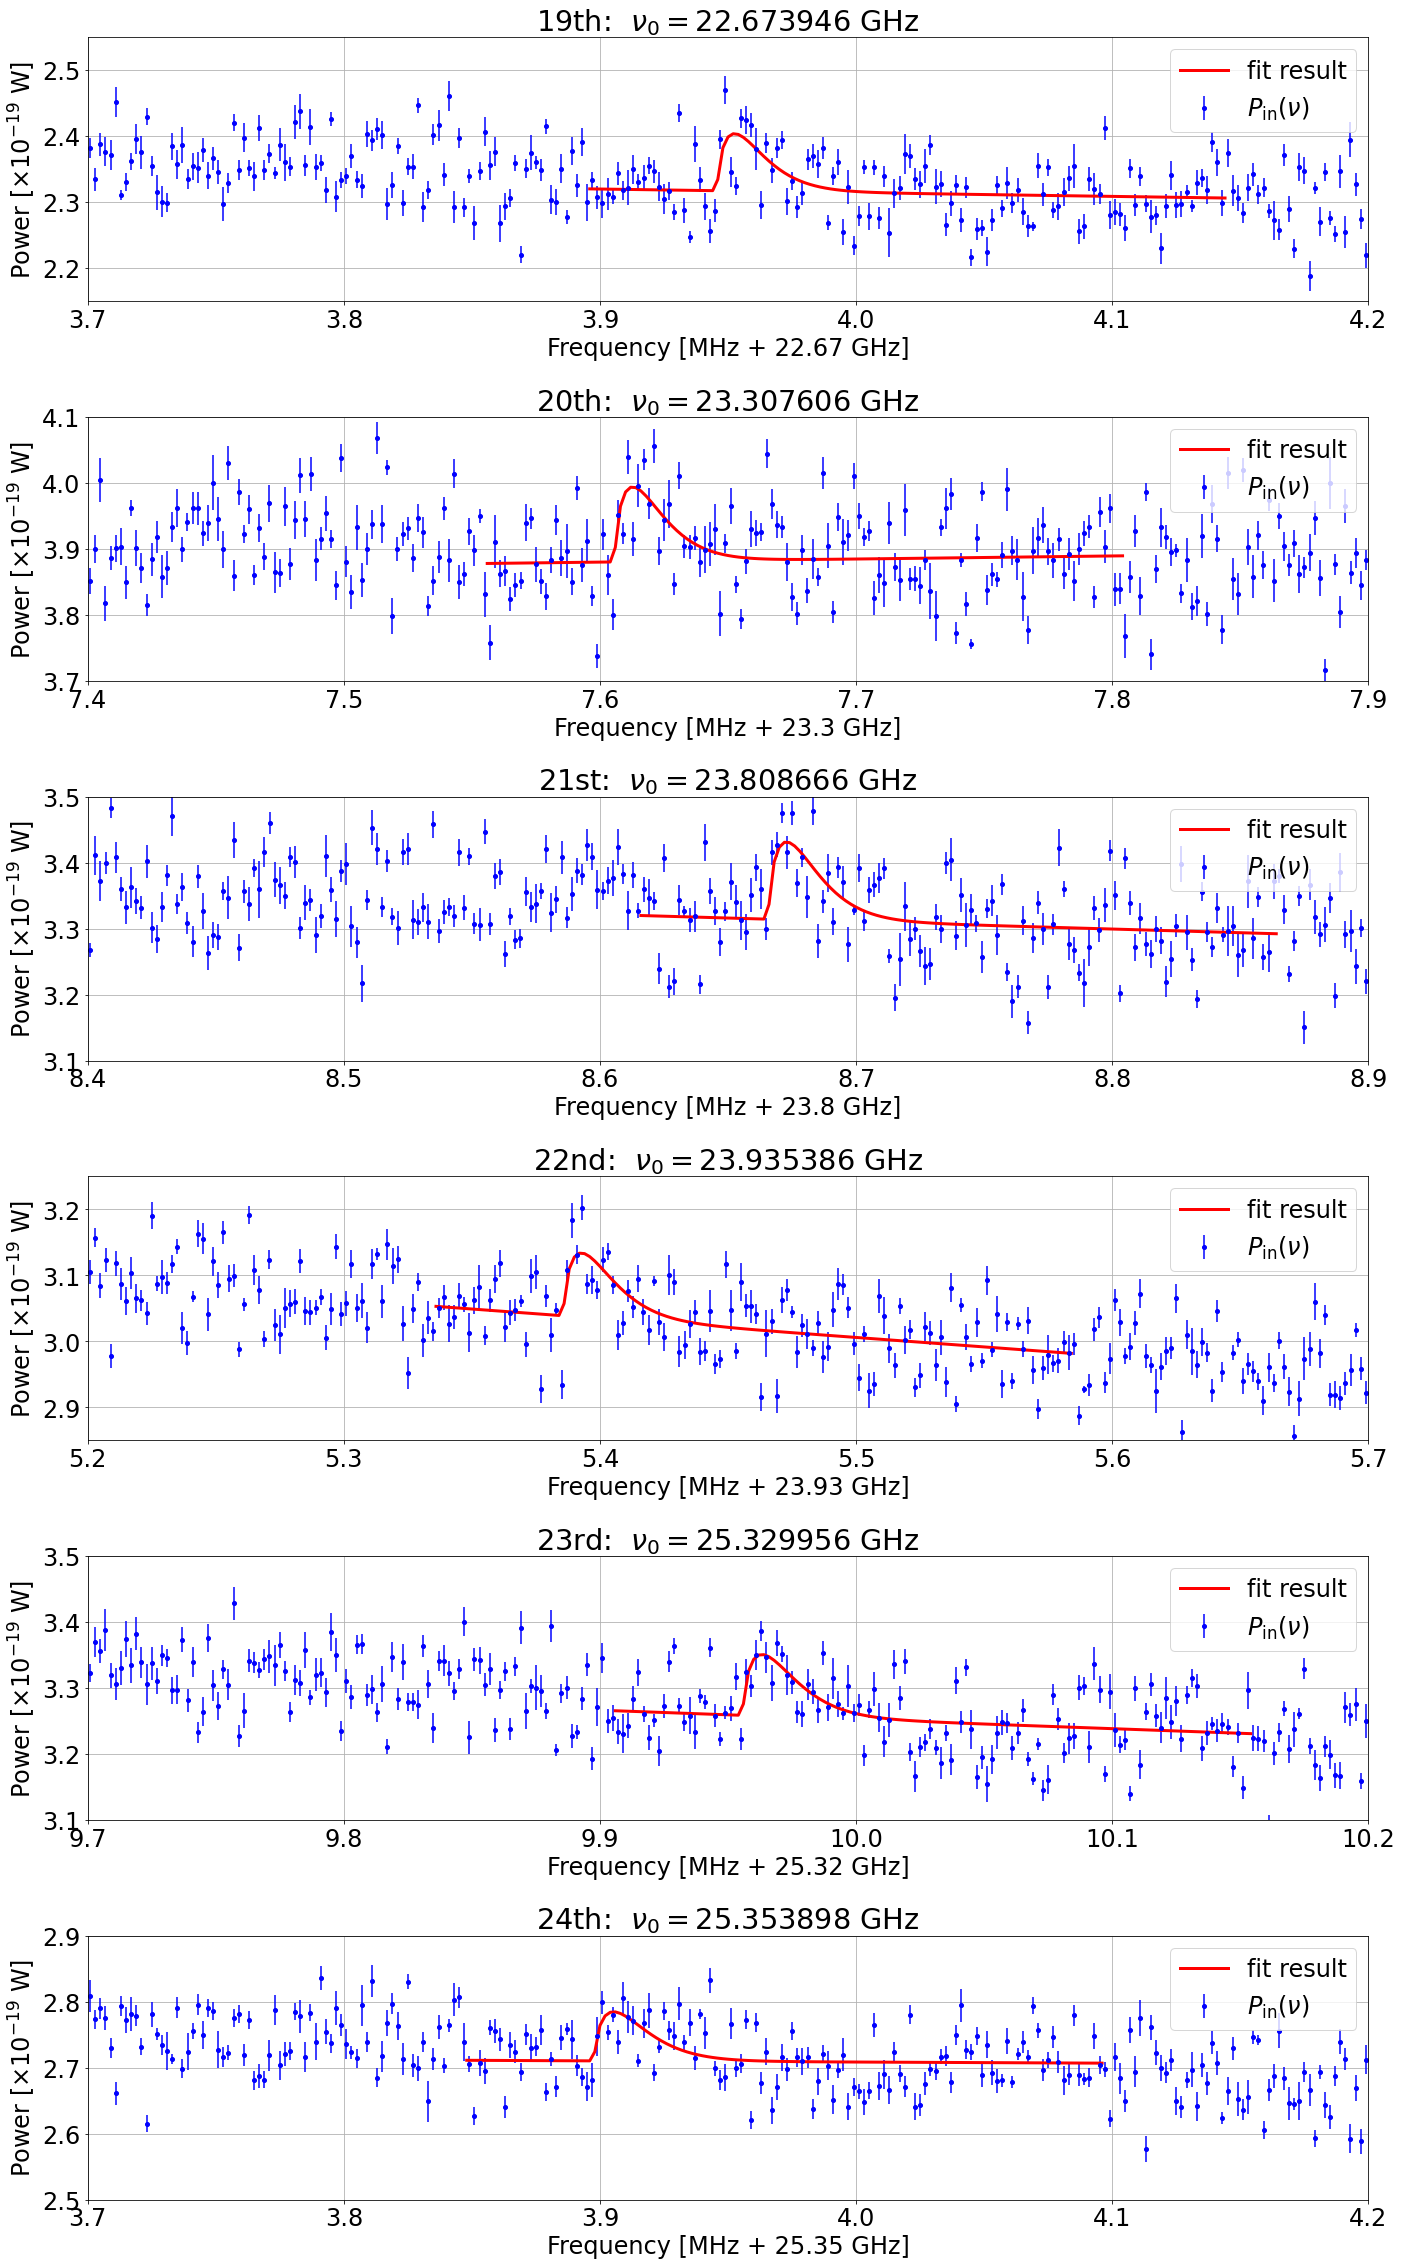

In [94]:
fig, axes = plt.subplots(6,1,figsize=(20,32), squeeze=False)
#fig = plt.subplots(figsize=(20,7))
plt.rcParams["font.size"] = 24

plot_peak2(22673946000.0, axes[0][0], 3.7, 2.15, "19th")
plot_peak(23307606000.0, axes[1][0], 7.4, 3.7, "20th")
plot_peak(23808666000.0, axes[2][0], 8.4, 3.1, "21st")
plot_peak(23935386000.0, axes[3][0], 5.2, 2.85, "22nd")
plot_peak2(25329956000.0, axes[4][0], 9.7, 3.1, "23rd")
plot_peak2(25353898000.0, axes[5][0], 3.7, 2.5, "24th")

                    
fig.tight_layout()


plt.savefig("../result_figure/under_1e5/from19to24.pdf")

In [48]:
4.5*10**1.5

142.30249470757707

In [ ]:
19187772000.0
20007980000.0
22673946000.0
25329956000.0
25353898000.0

# Plot the lowest p-Value fit

In [95]:
# Show frequency of the lowest p_local
f0 = round(freq_p_local_min, -3) # round by kHz
print(f0)

23935386000.0


In [106]:
# Retrieve data
base = np.floor(f0/1e7)*1e7*1e-9 #  GHz (100MHz each)
start = (int)(f0/2e6)*2e6*1e-3 - 250# kHz (2MHz each)
start = str(int(start)) # string
start = start[0:2]+'.'+start[2:] # GHz (2MHz each)
print(f'start = {start}')

# Retieve before data
## power
path = "/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start)
data = func.csv_to_array(path)
_W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]+data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
freq_before, W_before, We_before = func.rebin_func(data["freq"], _W)
## Fit func
path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
data = func.csv_to_array(path)
for i, freq_0 in enumerate(data["freq_0"]):
    if int(freq_0) == int(f0):
        freq_fit_before = np.arange(f0-50e3, f0+200e3, 2e3)
        fit_before = fit.fit_func(freq_fit_before, data["a"][i], data["b"][i], data["P"][i], f0)
        pass
    pass

# Retrieve after data
## Power
path = "/data/ms2840a/result_data/check_result/signal_12_data/start_{}GHz.csv".format(start)
data = func.csv_to_array(path)
_W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]+data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
freq_after, W_after, We_after = func.rebin_func(data["freq"], _W)
## Fit func
path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
data = func.csv_to_array(path)
for i, freq_0 in enumerate(data["freq_0"]):
    if int(freq_0) == int(f0):
        freq_fit_after = np.arange(f0-50e3, f0+200e3, 2e3)
        fit_after = fit.fit_func(freq_fit_after, data["a"][i], data["b"][i], data["P"][i], f0)
        pass
    pass

start = 23.933750


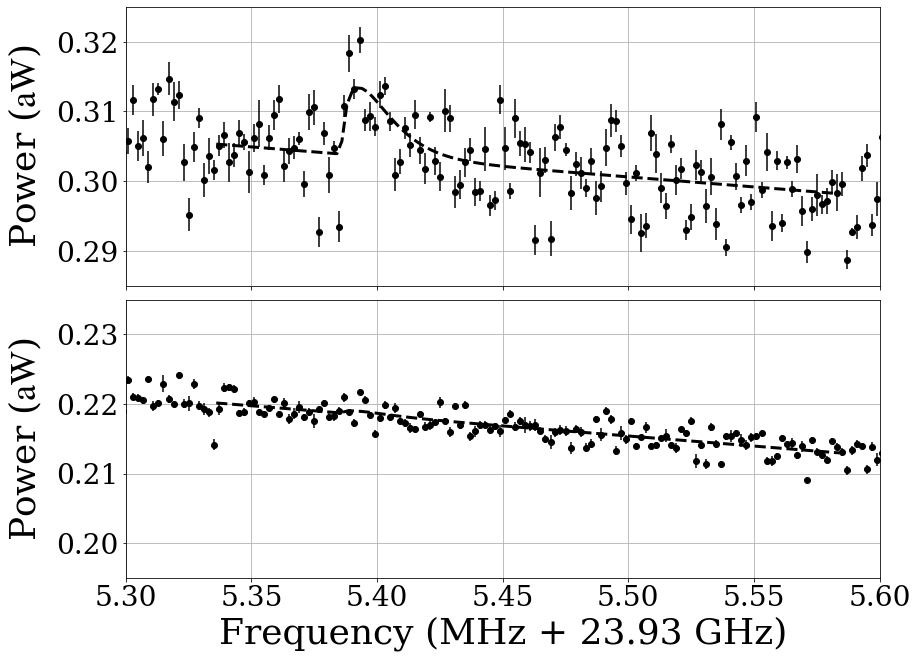

In [118]:
# Plot power before & after the additional measurement
outdir = './plot/result_figure/fit_result'
if not os.path.isdir(outdir): os.makedirs(outdir)
    
fig, axes = plt.subplots(2,1,figsize=(14,10), squeeze=False, sharex=True)
fig.tight_layout()
plt.rcParams["font.size"] = 28
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.family"] = 'serif'
W_conv = 1.e+18 # W --> aW

# Before
ax = axes[0][0]
ax.errorbar((freq_before*1e-9-base)*1e+3, W_before*W_conv, yerr=We_before*W_conv, fmt='o', markersize=6, color='black', label=r"$P_{\rm in}(\nu)$")
ax.plot((freq_fit_before*1e-9-base)*1e+3, fit_before*W_conv, color="black", linewidth=3, linestyle="--", label="fit result")
        
ax.grid()
#ax.legend(loc="upper right")
ax.set_xlim([5.3, 5.6])
ax.set_ylim([0.285, 0.325])
ax.set_yticks([0.29, 0.30, 0.31, 0.32])
ax.set_ylabel(r"Power ($\mathrm{aW}$)", labelpad=12, fontsize=36)
#ax.set_title(r"$\nu_0 = {}$ GHz".format(f0/1e9))

# After
ax = axes[1][0]
ax.errorbar((freq_after*1e-9-base)*1e+3, W_after*W_conv, yerr=We_after*W_conv, fmt='o', markersize=6, color='black', label=r"$P_{\rm in}(\nu)$")
ax.plot((freq_fit_after*1e-9-base)*1e+3, fit_after*W_conv, color="black", linewidth=3, linestyle="--", label="fit result")

ax.grid()
#ax.legend(loc="upper right")
ax.set_xlim([5.3, 5.6])
ax.set_ylim([0.195, 0.235])
ax.set_yticks([0.2, 0.21, 0.22, 0.23])
ax.set_xlabel("Frequency (MHz + {} GHz)".format(base), fontsize=36)
ax.set_ylabel(r"Power ($\mathrm{aW}$)", labelpad=12, fontsize=36)

# Cosmetic
fig.subplots_adjust(hspace=0.05, left=0.2, bottom=0.15)
plt.savefig(f"{outdir}/fit_p_local_min_gray.png")